In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Data Preprocessing
def extract_frames(video_path, max_frames=50):
    """Extract frames from a video file."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))
        frames.append(frame)
    cap.release()
    # Check if frames are empty and return a tensor with correct dimensions if it is
    if not frames:
        return torch.zeros(1, 224, 224, 3)  # Return a tensor with appropriate dimensions
    return np.array(frames)

def normalize_keypoints(keypoints, image_shape=(224, 224)):
    """Normalize keypoints based on image size."""
    h, w = image_shape
    keypoints[:, 0] = keypoints[:, 0] / w
    keypoints[:, 1] = keypoints[:, 1] / h
    return keypoints

class SignLanguageDataset(Dataset):
    def __init__(self, video_paths, labels, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        frames = extract_frames(video_path)
        if self.transform:
            # Apply the transform to each frame individually
            frames = [self.transform(frame) for frame in frames]
            # Stack the transformed frames into a single tensor
            frames = torch.stack(frames)
        return frames, label

def load_videos_from_folder(folder_path):
    """Load all video file paths from a folder."""
    video_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".mp4"):
            video_paths.append(os.path.join(folder_path, filename))
    return video_paths

# Example dataset and data loader
folder_path = '/content/drive/MyDrive/ISL_Sample Data'  # Replace with your folder path containing .mp4 files
video_paths = load_videos_from_folder(folder_path)
labels = list(range(len(video_paths)))  # Example labels, adjust as needed

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = SignLanguageDataset(video_paths, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Example iteration over dataloader
for batch in dataloader:
    frames, labels = batch
    print(frames.shape, labels)


torch.Size([2, 50, 3, 224, 224]) tensor([ 1, 40])
torch.Size([2, 50, 3, 224, 224]) tensor([50, 34])
torch.Size([2, 50, 3, 224, 224]) tensor([38, 44])
torch.Size([2, 50, 3, 224, 224]) tensor([29, 41])
torch.Size([2, 50, 3, 224, 224]) tensor([30, 10])
torch.Size([2, 50, 3, 224, 224]) tensor([ 8, 42])
torch.Size([2, 50, 3, 224, 224]) tensor([33, 31])
torch.Size([2, 50, 3, 224, 224]) tensor([46, 47])
torch.Size([2, 50, 3, 224, 224]) tensor([24, 49])
torch.Size([2, 50, 3, 224, 224]) tensor([19, 21])
torch.Size([2, 50, 3, 224, 224]) tensor([48, 45])
torch.Size([2, 50, 3, 224, 224]) tensor([28, 27])
torch.Size([2, 50, 3, 224, 224]) tensor([32,  6])
torch.Size([2, 50, 3, 224, 224]) tensor([12, 35])
torch.Size([2, 50, 3, 224, 224]) tensor([23, 14])
torch.Size([2, 50, 3, 224, 224]) tensor([ 9, 11])
torch.Size([2, 50, 3, 224, 224]) tensor([39, 51])
torch.Size([2, 50, 3, 224, 224]) tensor([ 0, 43])
torch.Size([2, 50, 3, 224, 224]) tensor([16, 13])
torch.Size([2, 50, 3, 224, 224]) tensor([26, 15])


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

# VGG-GRU Model with Improvements
class VGG_GRU(nn.Module):
    def __init__(self, num_classes):
        super(VGG_GRU, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features
        for param in self.vgg.parameters():
            param.requires_grad = False  # Freeze VGG layers to reduce overfitting on small dataset

        self.gru = nn.GRU(input_size=25088, hidden_size=512, num_layers=3, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.vgg(c_in)
        vgg_output_size = c_out.size(1) * c_out.size(2) * c_out.size(3)
        r_in = c_out.view(batch_size, timesteps, vgg_output_size)
        r_out, _ = self.gru(r_in)
        out = self.fc(r_out[:, -1, :])
        return out

# Pose-GRU Model with Improvements
class Pose_GRU(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Pose_GRU, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=512, num_layers=3, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        r_out, _ = self.gru(x)
        out = self.fc(r_out[:, -1, :])
        return out

# Pose-TGCN Model with Improvements
class Pose_TGCN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Pose_TGCN, self).__init__()
        self.graph_conv = nn.Conv1d(input_size, 256, kernel_size=1)  # Simplified GCN
        self.gru = nn.GRU(input_size=256, hidden_size=512, num_layers=3, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.graph_conv(x)
        x, _ = self.gru(x)
        out = self.fc(x[:, -1, :])
        return out

# I3D Model with Improvements
class I3D(nn.Module):
    def __init__(self, num_classes):
        super(I3D, self).__init__()
        self.i3d = models.video.r3d_18(pretrained=True)
        self.i3d.stem[0] = nn.Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)  # Adapting stem for more channels
        self.i3d.fc = nn.Linear(512, 256)  # Adjusting FC layer
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.i3d(x)
        x = self.dropout(x)
        out = self.fc(x)
        return out

# Optimizer and Learning Rate Scheduler
def get_optimizer_and_scheduler(model):
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    return optimizer, scheduler

# Example of defining transforms for data augmentation
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



Epoch 0/24
----------
Loss: 4.2074 Acc: 0.0000
Epoch 1/24
----------
Loss: 3.8430 Acc: 0.0755
Epoch 2/24
----------
Loss: 3.2441 Acc: 0.1321
Epoch 3/24
----------
Loss: 2.9000 Acc: 0.2264
Epoch 4/24
----------
Loss: 2.6521 Acc: 0.2642
Epoch 5/24
----------
Loss: 2.4530 Acc: 0.1698
Epoch 6/24
----------
Loss: 2.3531 Acc: 0.3585
Epoch 7/24
----------
Loss: 2.2177 Acc: 0.3019
Epoch 8/24
----------
Loss: 2.0410 Acc: 0.4340
Epoch 9/24
----------
Loss: 2.0306 Acc: 0.2642
Epoch 10/24
----------
Loss: 1.8583 Acc: 0.3774
Epoch 11/24
----------
Loss: 1.7041 Acc: 0.4906
Epoch 12/24
----------
Loss: 1.6981 Acc: 0.4906
Epoch 13/24
----------
Loss: 1.6782 Acc: 0.4528
Epoch 14/24
----------
Loss: 1.6225 Acc: 0.4906
Epoch 15/24
----------
Loss: 1.6060 Acc: 0.5472
Epoch 16/24
----------
Loss: 1.5798 Acc: 0.5283
Epoch 17/24
----------
Loss: 1.5616 Acc: 0.5283
Epoch 18/24
----------
Loss: 1.5421 Acc: 0.5283
Epoch 19/24
----------
Loss: 1.5196 Acc: 0.6038
Epoch 20/24
----------
Loss: 1.4587 Acc: 0.6415
Ep

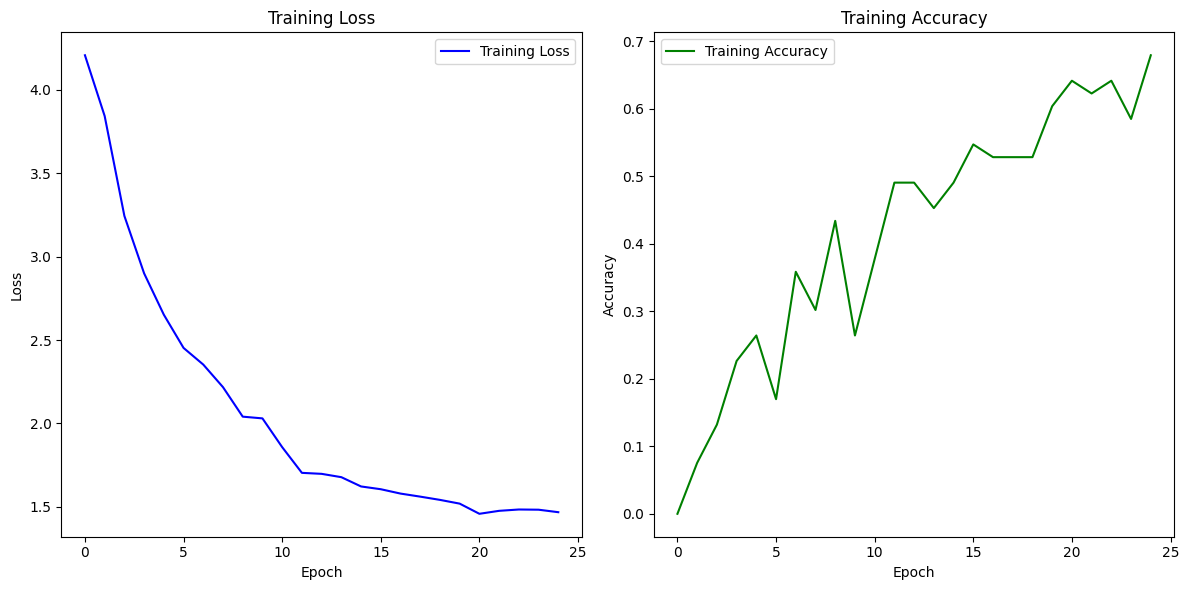

In [4]:



import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms

# Define the training function with improvements
def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=25):
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            # Move inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # GRU expects inputs as [batch_size, timesteps, input_size]
            batch_size, timesteps, C, H, W = inputs.size()  # Ensure inputs are in the correct shape
            inputs = inputs.view(batch_size, timesteps, -1)  # Flatten the spatial dimensions only

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()

            # Gradient Clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Adjust learning rate
        scheduler.step()

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())  # Convert tensor to float for logging

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, train_losses, train_accuracies

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Example of initializing the Pose_GRU model with the correct input size
model = Pose_GRU(input_size=224*224*3, num_classes=len(dataloader.dataset.labels))
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Define data augmentation and normalization for the dataset
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize dataloader with data augmentation
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2 )

# Train the model and retrieve losses and accuracies
model, train_losses, train_accuracies = train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=25)

# Plotting the training loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()





In [ ]:


# Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Reshape the input to be compatible with GRU
            batch_size, timesteps, C, H, W = inputs.size()
            input_size = C * H * W
            inputs = inputs.view(batch_size, timesteps, input_size)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f} %')
    return accuracy

# Assuming you have a separate test dataset and dataloader
# test_dataset = ...
# test_dataloader = ...

test_accuracy = evaluate_model(model, dataloader) # Use the same dataloader for demonstration

# Visualization (Example - Confusion Matrix)
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Reshape the input to be compatible with GRU
        batch_size, timesteps, C, H, W = inputs.size()
        input_size = C * H * W
        inputs = inputs.view(batch_size, timesteps, input_size)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
